In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

name_of_file = 'PD065_augm_8angles_4radii_80total'         # Название файла откуда считываются обработанные данные
number_of_groups = 4                # Количество интервалов на которые делятся прицельные параметры
number_of_epoches_conv = 100        # Количество эпох в обучении сверточной нейросети
number_of_epoches_lin = 100         # Количество эпох в обучении полносвязной нейросети
batch_size = 800                    # Размер батча


input_data = []
with open('data/' + name_of_file + '.dat', 'r') as inpf: 
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    maximum_hits = int(s[2])
    n_lines = int(s[4])
    number_of_features = n_lines * maximum_hits
    print(l)

    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])

        for digit in s[1:]:
            features.append(float(digit))
        input_data.append([b, features])
number_of_features = n_lines * maximum_hits

Maximum hits: 80 Lines: 3



Были прицельные параметры: 
 [[ 4.494]
 [ 8.925]
 [14.58 ]
 [ 9.909]
 [ 8.487]
 [ 9.831]]
Length of segment: 11000
Encoded into intervals: [(0, 6.974), (6.974, 9.814), (9.814, 12.043), (12.043, 16.347)]
Закодированы в интервалы: 
 [[0]
 [1]
 [3]
 [2]
 [1]
 [2]]
Размеры тренировочного и тестового наборов:
Set shape: (44000, 240)
Train features shape: torch.Size([35200, 1, 3, 80])
Train labels shape: torch.Size([35200])
Test features shape: torch.Size([8800, 1, 3, 80])
Test labels shape: torch.Size([8800])

Пример как выглядит картина для сверточной нейросети


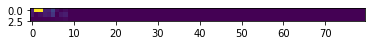

In [2]:
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels[idx]
        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}

        return sample


# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    
    # define borders of segments
    for i in range(groups):   
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=np.int)
    incr = 0
    
    # iterate over all (not sorted) labels and encode them
    for elem in labels:   
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()




np.random.shuffle(input_data)
input_sorted = sorted(input_data, key=lambda x: (x[0]))
    
features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    labels[incr] = np.array(elem[0])
    features[incr] = np.array(elem[1])
    incr += 1
    

# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets
print("Были прицельные параметры: \n {}".format(labels[:6]))
labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print("Закодированы в интервалы: \n {}".format(labels_encoded_equisized[:6]))
train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))

# Divide features into test and training sets
# For convolutional
features_reshaped = np.reshape(features, (features.shape[0], 1, n_lines, maximum_hits))
train_features_c = torch.tensor(features_reshaped[:size_of_training_set], dtype=torch.float32)
test_features_c = torch.tensor(features_reshaped[size_of_training_set:], dtype=torch.float32)
# For fully connected
train_features_lin = torch.tensor(features[:size_of_training_set], dtype=torch.float32)
test_features_lin = torch.tensor(features[size_of_training_set:], dtype=torch.float32)

print("Размеры тренировочного и тестового наборов:")
print('Set shape: ' + str(features.shape))
print('Train features shape: ' + str(train_features_c.shape))
print('Train labels shape: ' + str(train_labels.shape))
print('Test features shape: ' + str(test_features_c.shape))
print('Test labels shape: ' + str(test_labels.shape))
print("\nПример как выглядит картина для сверточной нейросети")
# print(train_features_c[0][0])
plt.imshow(train_features_c[0][0])
plt.show()


In [3]:
# Linear Fully connected network. 
# Convolutional - three blocks below

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = 128, out_features = 64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = 64, out_features = 32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        self.lin4 = nn.Linear(in_features = 32, out_features = 12)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 32, out_features = 20)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 20, out_features = 12)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = 12, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t


In [4]:
# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features_lin)
teDS = DatasetNN(test_labels, test_features_lin)
trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
teDL = torch.utils.data.DataLoader(trDS, batch_size=len(teDS))

net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.01)

loss_weights = torch.ones(number_of_groups)

total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []

# Learning process
for epoch in range(number_of_epoches_lin):
    total_correct = 0
    t_loss = 0
    for batch in trDL:
        batch_labels = batch['label']
        batch_features = batch['feature']

        predicted = net(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += (loss.item() * batch_size/len(trDS))
        total_correct += get_correct_predictions(predicted, batch_labels)

    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
        .format(epoch, t_loss, total_correct, total_correct*100/train_features_lin.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(t_loss)
        total_accuracy.append(total_correct*100/train_features_lin.shape[0])
        
        test_preds = net(test_features_lin)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features_lin.shape[0])

Epoch:    0 |---> loss is 1.2567146610, total correct predictions: 16687, its 47.406%
Epoch:    1 |---> loss is 1.1241921295, total correct predictions: 22690, its 64.460%
Epoch:    2 |---> loss is 1.0772723854, total correct predictions: 23710, its 67.358%
Epoch:    3 |---> loss is 1.0907161480, total correct predictions: 22935, its 65.156%
Epoch:    4 |---> loss is 1.0879140876, total correct predictions: 23027, its 65.418%
Epoch:    5 |---> loss is 1.0981540490, total correct predictions: 22698, its 64.483%
Epoch:    6 |---> loss is 1.0917432362, total correct predictions: 22924, its 65.125%
Epoch:    7 |---> loss is 1.0906634114, total correct predictions: 22909, its 65.082%
Epoch:    8 |---> loss is 1.0778805722, total correct predictions: 23361, its 66.366%
Epoch:    9 |---> loss is 1.0864529718, total correct predictions: 23090, its 65.597%
Epoch:   10 |---> loss is 1.1471081403, total correct predictions: 20972, its 59.580%
Epoch:   11 |---> loss is 1.1465238035, total correct 

Test accuracy is 43.10%


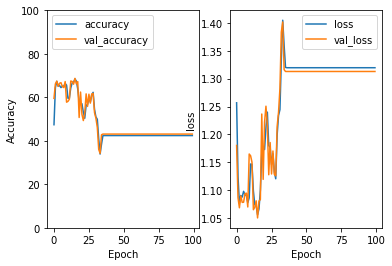

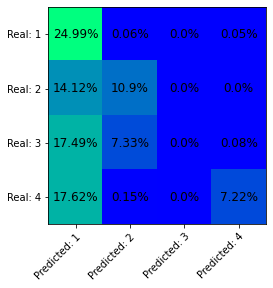

In [5]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features_lin)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions * 100 /test_features_lin.shape[0]))
    
    # Creating of confusion matrix
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    # horizontal axis - predicted, vertical - true
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features_lin.shape[0], 2)) + '%', ha="center", va="center", size=12)


In [6]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(3, 3))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        # print(self.conv1.weight)
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        
        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        # self.lin1 = nn.Linear(in_features=4*(int((maximum_hits - 1)/2) - 2), out_features=60)
        self.lin1 = nn.Linear(in_features=4*(int((maximum_hits)/2) - 2), out_features=60)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=60, out_features=16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        # self.lin3 = nn.Linear(in_features=30, out_features=12)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=30, out_features=16)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=16, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = t
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, 4*(int((maximum_hits)/2) - 2))))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t


In [7]:
# В этом блоке - сам процесс обучения
trainDS = DatasetNN(train_labels, train_features_c)
testDS = DatasetNN(test_labels, test_features_c)
train_dataloader = torch.utils.data.DataLoader(trainDS, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testDS, batch_size=len(testDS))

net_c = NetworkConv()
optimizer_c = optim.Adam(net_c.parameters(), lr=0.001, weight_decay=0.0001)

# Here define weights for loss contribution of segments
loss_weights_c = torch.ones(number_of_groups)

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    total_correct_c = 0
    t_loss = 0.0
    for batch in train_dataloader:
        batch_labels = batch['label']
        batch_features = batch['feature']

        predicted_c = net_c(batch_features)
        loss_c = F.cross_entropy(predicted_c, batch_labels, loss_weights_c)
        optimizer_c.zero_grad()
        loss_c.backward()
        optimizer_c.step()
        t_loss += (loss_c.item() * batch_size / len(trainDS))
        total_correct_c += get_correct_predictions(predicted_c, batch_labels)
    
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, t_loss, total_correct_c, total_correct_c*100/train_features_c.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)
        total_accuracy_c.append(total_correct_c*100/train_features_c.shape[0])
        
        test_preds_c = net_c(test_features_c)
        total_val_loss_c.append(F.cross_entropy(test_preds_c, test_labels, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds_c, test_labels)*100/test_features_c.shape[0])

Epoch:    0 |---> loss is 1.3301450231, total correct predictions: 14369, its 40.821%
Epoch:    1 |---> loss is 1.2114740746, total correct predictions: 20032, its 56.909%
Epoch:    2 |---> loss is 1.1106176512, total correct predictions: 23632, its 67.136%
Epoch:    3 |---> loss is 1.0598217330, total correct predictions: 24287, its 68.997%
Epoch:    4 |---> loss is 1.0451687005, total correct predictions: 24489, its 69.571%
Epoch:    5 |---> loss is 1.0405018086, total correct predictions: 24585, its 69.844%
Epoch:    6 |---> loss is 1.0365343419, total correct predictions: 24703, its 70.179%
Epoch:    7 |---> loss is 1.0328246382, total correct predictions: 24899, its 70.736%
Epoch:    8 |---> loss is 1.0300074464, total correct predictions: 24993, its 71.003%
Epoch:    9 |---> loss is 1.0274017860, total correct predictions: 25072, its 71.227%
Epoch:   10 |---> loss is 1.0247270072, total correct predictions: 25117, its 71.355%
Epoch:   11 |---> loss is 1.0235378634, total correct 

Test accuracy is 73.97%


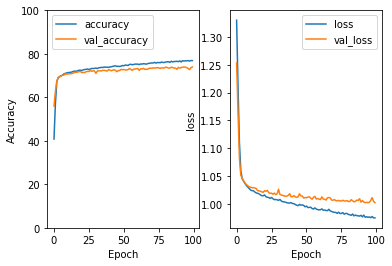

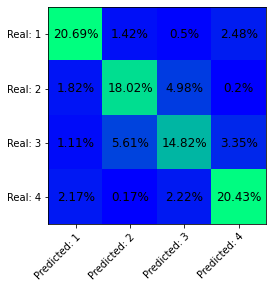

In [8]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features_c)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels)
    test_accuracy = test_correct_predictions_c * 100 /test_features_c.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy))
    
    with open('some_results.txt', 'a') as batch_results:
        batch_results.write('| {:7d}     | {:7d}     | {:7.2f}  |\n'.format(batch_size, number_of_epoches_conv, test_accuracy))

    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features_c.shape[0],2)) + '%', ha="center", va="center", size=12)